Project for the course in Microeconometrics | Summer 2020, M.Sc. Economics, Bonn University | Felix Kirsch

<h1>Replication of Angrist and Krueger (1991)</h1>

<h2 id='intro'>1. Introduction</h2>

Angrist and Krueger present estimates of the return to education, using season of birth as instrument for completed years of schooling. The relation of season of birth to school attendance is caused by interaction of compulsory schooling laws and school enrollment policies. Compulsory schooling attendance prohibits students to drop out of school, before they have reached a certain age. Normally, school enrollment policies require students to have passed the age of six at the beginning of the year, in which they start to attend school. Therefore, students who are born at the beginning of the year, start school at an older age than those who are born later in the year. In combination with the compulsory school attendance laws, this enables individuals born at the beginning of the year to drop out of school with less years of schooling completed. Under the assumption that the fraction of students who want to leave school is independent from season of birth, students born later in the year are constrained to attend school longer. So, compulsory schooling laws introduce  a variation of school attendance dependening on the season of birth. Since time of birth is most likely uncorrelated to other personal characteristics, Angrist and Krueger use the variation to estimate the return to education.

In the first section of their paper, the authors examine the relation between years of education and season of birth using data from the 1970 and 1980 US Census. They investigate the effect of quarter of birth on various educational outcome variables.
In the second section, the return to education is estimated using a two stage least squares approach. Thereby, quarter of birth is used as instrument for years of education. Angrist and Krueger present various results, comparing OLS and TSLS and using different control variables.

This notebook is structured as follows: In the next section the identification strategy is presented, then the results of Angrist and Krueger (1991) are replicated. In the fourth section possible problems with weak instruments, multicollinearity and memory usage are examined. The fifth section concludes.

<h2>Table of Contents</h2>
<ul>
    <li><a href="#intro">1. Introduction</a></li>
    <li><a href="#ident">2. Identification</a></li>
    <li><a href="#repli">3. Replication of Angrist and Krueger (1991)</a></li>
    <ul>
        <li><a href="#data">3.1 Data & Descriptive Statistics</a></li>
        <li><a href="#season">3.2 Season Of Birth, Compulsory Schooling, And Years Of Education</a></li>
        <li><a href="#esti">3.3 Estimating The Return To Education</a></li>
        <ul>
            <li><a href='#tsls'>3.3.1 TSLS Estimates</a></li>
            <li><a href ='#state'>3.3.2 Allowing the Seasonal Pattern in Education to Vary by State of Birth</a></li>
            <li><a href ='#black'>3.3.3Estimates for Black Men</a></li>
        </ul>
    </ul>
    <li><a href='#ext'>4. Extensions</a></li>
    <ul>
        <li><a href='#weak'>4.1 Problems with Weak Instruments</a></li>
        <ul>
            <li><a href="#incst">4.1.1 Inconsistency</a></li>
            <li><a href="#finite">4.1.2 Finite-Sample Bias</a></li>
            <li><a href="#bias">4.1.3 The Bias of 2SLS</a></li>
        </ul>
        <li><a href='#multcoll'>4.2 Problems with Multicollinearity</a></li>
        <ul>
            <li><a href="#vif">4.2.1 Variance Inflation Factor</a></li>
        </ul>
        <li><a href="#mem">4.3 Problems with Memory Usage</a></li>
    </ul>
    <li><a href='#concl'>5. Conclusion</a></li>
    <li><a href='#ref'>6. References</a></li>
</ul>

In [1]:
import matplotlib
import mock
import numpy as np
from operator import itemgetter
import pandas as pd
import patsy
import seaborn as sns
import statsmodels.formula.api as smf
from collections import namedtuple
from linearmodels.iv.model import IV2SLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS

from IPython.display import HTML, Image

import auxiliary.data_helper as dhlp
import auxiliary.figures as fgrs
import auxiliary.tables as tbl
import auxiliary.regressions as rgr

pd.set_option('precision', 2)
matplotlib.rcParams['figure.figsize'] = [10, 5]

<h2 id="ident">2. Identification</h2>

Angrist and Krueger aim to get an unbiased estimate of the return to education. Estimates of the return to education are likely to suffer from omitted variable bias. Unobserved influence factors, like ability, are positively correlated with education and earnings. Individuals with high ability tend to have higher education than individuals with low ability, because the additional effort for more education is lower for individuals with high ability. Also, it is clear, that the labor market pays higher wages for individuals with higher ability. Ability is hard to measure and therefore it is not possible to control for ability, when estimating the return to education. Therefore, an omitted variable bias might occur.

Angrist and Krueger examine the effect of compulsory schooling laws in the US. Compulsory schooling requires students to reach a certain age before they are allowed to leave school. Moreover, school start policies require the students to have reached a certain age at the beginning of the year, in which they can start school. Typically, individuals begin school in fall of the year, in which they turn age six and have to attend school at minimum until they turn age sixteen. The combination of this restrictions requires students born in the end of the year to attend school longer than students born in the beginning of the year. Because students born early in the year start school at an older age and are able to drop out of school earlier than their classmates born later in the year, they have to obtain less years of schooling. For example, students, who want to leave school after completing the tenth grade, can do so only if they were born in the first half of the year. Assuming that the fraction of students, who want to drop out of school, is independent of quarter of birth, students born near later in the year obtain more average years of schooling than students born early in the year.

The analysis of the census data yields indeed the expected pattern in mean education regarding the quarter of birth. Children born in the first quarter have in average lower completed years of schooling than children born later in the year. Angrist and Krueger use this exogenous variation in education due to quarter of birth to estimate the return of education using an instrumental variable approach.

In order to be a valid instrument, the effect of quarter of birth on wage must be fully induced by its effect on education. Further, the relation between quarter of birth and education is only due to the effect of compulsory schooling laws. Since day of birth is most likely unrelated to ability, motivation or other personal attributes, these assumptions are fullfilled.

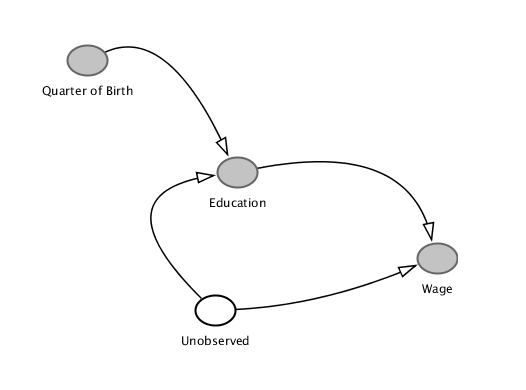

In [2]:
Image('files/causal_graph_angrist.png')

<h2 id='repli'>3. Replication of Angrist and Krueger (1991)</h2>

<h3 id='data'>3.1 Data & Descriptive Statistics</h3>

The results of Angrist and Krueger are based on micro data from the 1970 Census and the 1980 Census. They created extracts from both census, provided <a href="https://economics.mit.edu/faculty/angrist/data1/data/angkru1991">here</a>. The extract of the 1970 census consists of white and black men born between 1920-1929 in the United States. The extract of the 1980 census consists of white and black men born between 1930-1959. To both extracts weakly earnings and birth year were added, the method of construction is described in the appendix of Angrist and Krueger (1991). Individuals with information allocated by the Census Bureau were excluded. Also, for the 1970 extract only men with positive wage, earnings and weeks worked in 1969 were included. Similarly, for the 1980 extract only men with positive wage, earnings and weeks worked in 1979 were included.

Both extract contain quarter of birth (QOB), year of birth (YOB), age and age accurate to the quarter of birth (AGEQ). The education variable (EDUC) describes years of completed schooling. There are eight dummies for region of residence (ENOCENT, ESOCENT, MIDATL, MT, NEWENG, SOATL, WNOCENT, WSOCENT), a dummy for race (RACE, 1 = black), a dummy for martial status(MARRIED, 1 = married) and a dummy for residence in a standard metropolitan staticstical area (SMSA, 1 = city center). Furthermore, the state variable describes the state of birth.

The authors divide the date in three cohorts, which are examined seperately. Men born from 1920-29 from the 1970 census, men  born from 1930-39 and men born from 1940-49 from the 1980 census.

In [3]:
# get data from the 1970 census
df = dhlp.get_df_census70()
df.describe().loc[['mean', 'std', 'min', 'max']]

,AGE,AGEQ,EDUC,ENOCENT,ESOCENT,LWKLYWGE,MARRIED,MIDATL,MT,NEWENG,CENSUS,STATE,QOB,RACE,SMSA,SOATL,WNOCENT,WSOCENT,YOB
mean,44.73,45.10,11.49,0.22,0.06,5.15,0.89,0.2,0.04,0.05,70.0,31.83,2.49,0.08,0.30,0.15,0.07,0.09,1924.53
std,2.90,2.88,3.36,0.41,0.23,0.65,0.31,0.4,0.19,0.22,0.0,15.81,1.11,0.27,0.46,0.36,0.26,0.28,2.86
min,40.00,40.25,0.00,0.00,0.00,-0.02,0.00,0.0,0.00,0.00,70.0,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1920.00
max,50.00,50.00,18.00,1.00,1.00,8.95,1.00,1.0,1.00,1.00,70.0,99.00,4.00,1.00,1.00,1.00,1.00,1.00,1929.00


In [4]:
# get data form the 1980 census
df = dhlp.get_df_census80()
# summary statistics for 1930 - 39 Births
df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)].describe().loc[['mean', 'std', 'min', 'max']]

,AGE,AGEQ,EDUC,ENOCENT,ESOCENT,LWKLYWGE,MARRIED,MIDATL,MT,NEWENG,CENSUS,STATE,QOB,RACE,SMSA,SOATL,WNOCENT,WSOCENT,YOB
mean,44.65,45.02,12.77,0.2,0.07,5.90,0.86,0.16,0.05,0.06,80.0,30.69,2.51,0.08,0.19,0.17,0.08,0.1,34.6
std,2.94,2.92,3.28,0.4,0.25,0.68,0.34,0.37,0.22,0.23,0.0,14.22,1.11,0.27,0.39,0.37,0.27,0.3,2.9
min,40.00,40.25,0.00,0.0,0.00,-2.34,0.00,0.00,0.00,0.00,80.0,1.00,1.00,0.00,0.00,0.00,0.00,0.0,30.0
max,50.00,50.00,20.00,1.0,1.00,10.53,1.00,1.00,1.00,1.00,80.0,56.00,4.00,1.00,1.00,1.00,1.00,1.0,39.0


In [5]:
# summary statistics for 1940 - 49 Births
df.loc[(df['YOB'] >= 40) & (df['YOB'] <= 49)].describe().loc[['mean', 'std', 'min', 'max']]

,AGE,AGEQ,EDUC,ENOCENT,ESOCENT,LWKLYWGE,MARRIED,MIDATL,MT,NEWENG,CENSUS,STATE,QOB,RACE,SMSA,SOATL,WNOCENT,WSOCENT,YOB
mean,34.32,34.69,13.57,0.2,0.07,5.80,0.8,0.15,0.05,0.06,80.0,30.13,2.54,0.08,0.19,0.17,0.08,0.1,44.92
std,2.87,2.86,2.98,0.4,0.25,0.65,0.4,0.36,0.22,0.23,0.0,14.53,1.12,0.27,0.39,0.38,0.27,0.3,2.84
min,30.00,30.25,0.00,0.0,0.00,-2.34,0.0,0.00,0.00,0.00,80.0,1.00,1.00,0.00,0.00,0.00,0.00,0.0,40.00
max,40.00,40.00,20.00,1.0,1.00,11.23,1.0,1.00,1.00,1.00,80.0,56.00,4.00,1.00,1.00,1.00,1.00,1.0,49.00


Mean education increases across the cohorts. While men born between 1920 and 1929 only had on average 11.49 completed years of schooling, men born from 1930-39 had on average 12.77 and men born form 1940-49 had on average 13.57 completed years of schooling. The average weakly wage increases from the 1920-29 cohort to the 1930-39 cohort and then slightly reduces for the 1940-49 cohort. The proportion of married men is decreasing from 89% to 80%, share of black men and share of men living in a SMSA are stable.

<h3 id='season'>3.2 Season Of Birth, Compulsory Schooling, And Years Of Education</h3>

Due to compulsory school attendance laws, the average years of completed schooling are expected to change across individuals born in different quarters of the year. Angrist and Krueger investigate for the correlation between quarter of birth and completed years of schooling in the data. If the hypothese is true, a seasonal pattern should be observable in the data: students born early in year should on average have completed less years of schooling than students born later in year.

The following figures show the relationship between the years of education and season of birth for the 1930-39 and the 1940-49 cohort. The graph displays the average years of completed education.

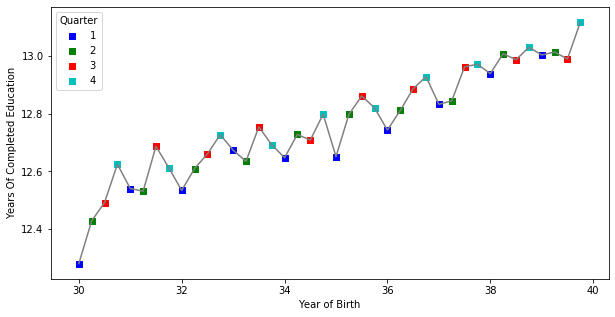

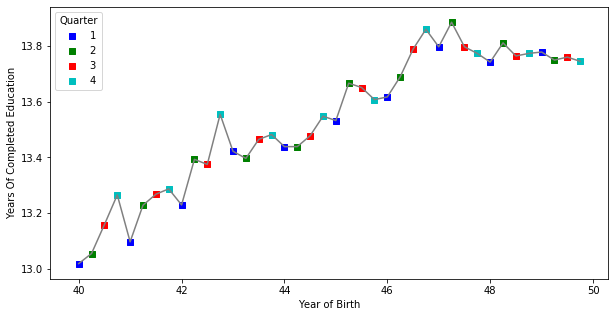

In [6]:
fgrs.plot_educ_against_yob(df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)])
fgrs.plot_educ_against_yob(df.loc[(df['YOB'] >= 40) & (df['YOB'] <= 49)])

The average years of completed education increases from 1930 to 1950. This trend is pronounced from 1930-47 and then the curve flattens out. Further, there is a clear relationship between number of years of completed education and quarter of birth. Education is higher for students born in the end of the year than for students born in the beginning of the year. While this effect could also be explained by the overall trend, the observation, that most times the average education for men born in the fourth quarter is higher than for men born in the first quarter of the next year, is not caused by the trend. Also, the years of completed education of students born in the third quarter are often higher than of the students born in the first quarter of the next year.
The seasonal pattern is more pronounced in the first figure for men born between 1930 and 1939.

For further examination of this pattern, Angrist and Krueger remove the trend in years of education inside the observations. The detrended average is computed by subtracting a moving average. This two-sided moving average is computed for each quarter using the average education of the two preceeding and the two succeeding quarters:

$$ MA_{cj} = (E_{-2} + E_{-1} + E_{+1} + E_{+2}) / 4 $$

$MA_{cj}$ is the moving average for students born in year $c$ and quarter $j$. $E_q$ is the average education for students born $q$ quarters before or after students born in quarter $j$. The detrended average education is $E_{cj} - MA_{cj}$.

In [7]:
def two_sided_moving_average(x):

    # construct array initialized with nans
    ma = np.full_like(x, np.nan)

    # compute the moving average for each group which has two preceeding and two succeding quarters
    for i in range(2, len(x) - 2):
        ma[i] = (x[i - 2] + x[i - 1] + x[i + 1] + x[i + 2]) / 4

    return ma

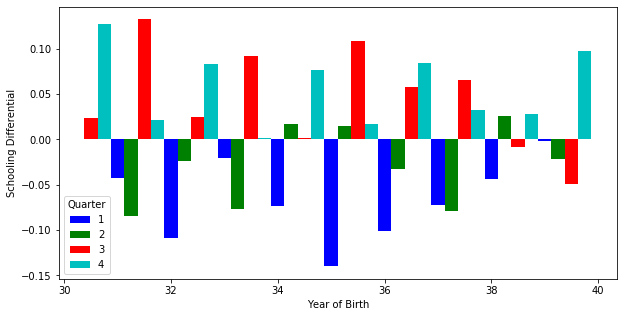

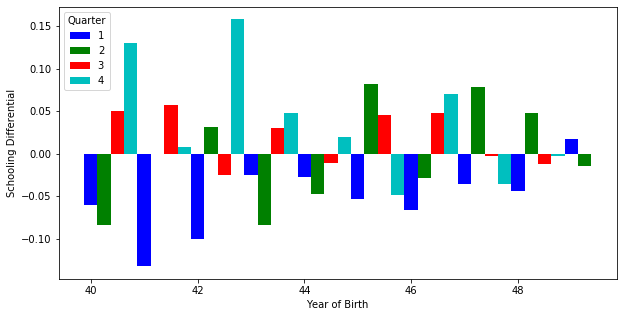

In [8]:
# compute the average years of schooling for each cohort c, j
mean_educ = df.groupby(['YOB', 'QOB'])['EDUC'].mean().to_frame()
# apply the formula for the moving average
mean_educ['MV_AVG'] = two_sided_moving_average(mean_educ.values)
# compute the detrended education
mean_educ['DTRND'] = mean_educ['EDUC'] - mean_educ['MV_AVG']

fgrs.plot_bar_detrended_educ(mean_educ.loc[range(30, 40)])
fgrs.plot_bar_detrended_educ(mean_educ.loc[range(40, 50)])

The figures clearly approve the seasonal pattern observed in the prior graphs. Only one time the average years of schooling of men born in the first quarter exceed the moving average. Individuals born in the first and second quarter most of the time have less education than the moving average and individuals born in the third and fourth quarter, most of the time, have more education than the moving average.

To quantify the effect of quarter of birth on completed years of education, Angrist and Krueger calculate regressions, using the following formula:

$$(E_{icj} - MA_{cj}) = \alpha + \sum^{3}_{j}{\beta_{j} Q_{icj}} + \epsilon_{icj}$$
$$for \space i = 1, \dots, N_{c}; \space c = 1, \dots , 10; \space j = 1, 2, 3;$$

$E_{icj}$ represents the educational outcome variable for individual $i$ in cohort $c$. The authors run regressions on total years of education, high school graduation, years of education for high school graduates, college graduation, completed master's degree and completed doctoral degree. $MA_{cj}$ is the two-period, two-sided moving average of the corresponding outcome variable. $Q_{icj}$ is a dummy variable, which specifies if individual $i$ was born in the $j$th quarter of the year.
By construction of the moving average, it is necessary to exclude the first two and the last two observations from the regressions.

For constructing the educational outcome variables, Angrist and Krueger assume, that individuals with sixteen or more years of education have a college degree, individuals with eightteen or more years of education have a master's degree and individuals with twenty or more years of education have a doctoral degree.

In [9]:
educ_vars = ['EDUC', 'DUMMY_HIGH_SCHOOL', 'DUMMY_COLLEGE', 'DUMMY_MASTER', 'DUMMY_DOCTOR']

# add dummy variables
df = dhlp.add_quarter_of_birth_dummies(df)
df = dhlp.add_education_dummies(df)
df = dhlp.add_detrended_educational_variables(df, educ_vars = educ_vars)

cohort30 = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)].dropna()
cohort40 = df.loc[(df['YOB'] >= 40) & (df['YOB'] <= 49)].dropna()

cohorts = [('1930-1939', cohort30), ('1940-1949', cohort40)]

# run regressions on the educational variables for the two cohorts
results = rgr.get_regression_results_educational_variables(educ_vars, cohorts)

# select high school graduates
cohort30_high_school = cohort30.loc[cohort30['DUMMY_HIGH_SCHOOL'] == 1]
cohort40_high_school = cohort40.loc[cohort40['DUMMY_HIGH_SCHOOL'] == 1]

cohorts_high_school = [('1930-1939', cohort30_high_school), ('1940-1949', cohort40_high_school)]

# estimate the effect of quarter of birth on education for high school graduates
results[4:4] = rgr.get_regression_results_educational_variables(['EDUC'], cohorts_high_school)

HTML(tbl.create_table_qob(results, outcome_variables = ['Total years of education', '', \
                                                        'High school graduate', '', \
                                                        'Years of educ. for high school graduates', '', \
                                                        'College graduate', '', \
                                                        "Completed master's degree", '', \
                                                        'Completed doctoral degree', '']))

The estimates in the table show the effect of quarter of birth on the outcome variables relative to individuals born in the fourth quarter. For each outcome variable regressions are run for men born between 1930-39 and men born between 1940-49. The standard errors are in parantheses below the estimates. The F-Tests test the hypothesis that all quarter-of-birth dummies have jointly no effect.

The effect of quarter of birth on total years of education is highly significant. In both cohorts men born in the fourth quarter on average receive more education than men born in the other quarter. This effect is especially pronounced for men born in the first quarter. For the 1930 cohort men born in the first or second quarter are approximately 2 percentage points less likely to obtain a high school degree. For the 1940 cohort men born in the first quarter are 1.5 percentage points less likely and men born in the second quarter 1.2 percentage points less likely to obtain a high school degree. The effect of quarter of birth on high school graduation is also highly significant.
The observations are consistent with the expected seasonal pattern caused by school start policies and compulsory school attendance.

The regressions on the further educational variables should examine, if quarter of birth also have an effect on education for individuals, who are not constraint by compulsory schooling laws. If the variation in years of education is due to compulsory schooling, the seasonal pattern disappear for cohort not constrained by compulsory schooling.

For cohorts with at least a high school degree the pattern changes and is less pronounced. Individuals born in the second and third quarter tend to have more years of education on average. The differences between quarter of birth in the regressions on college graduation, completed master's degree and completed doctoral degree are mostly insignificant. The significance of the F-Test that all quarter of birth dummies have jointly no effect is small.

<h3 id="esti">3.3 Estimating The Return To Education</h3>

Angrist and Krueger examine if the small variation in completed years of schooling results in differences in earnings.
To get a first impression, the following figure shows log weekly wages by quarter of birth.

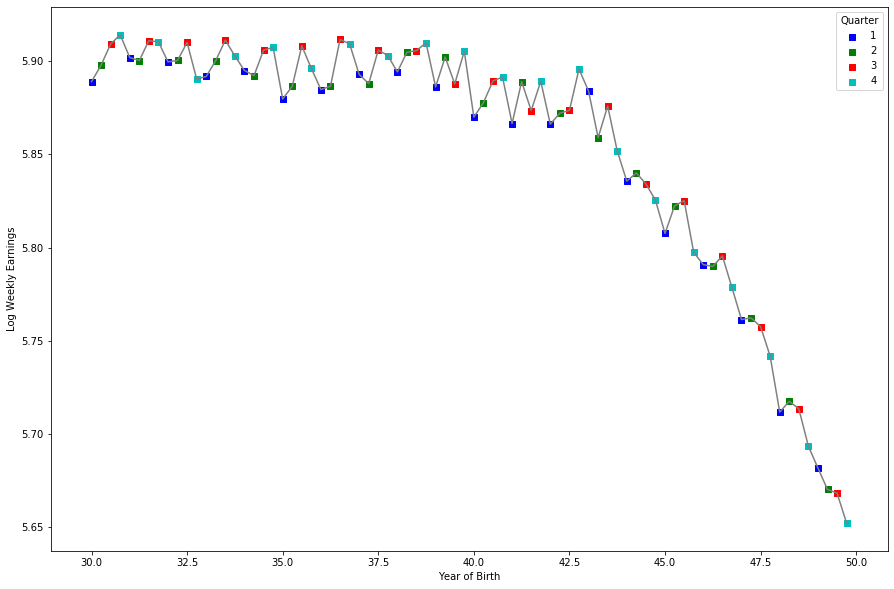

In [10]:
matplotlib.rcParams['figure.figsize'] = [15, 10]
fgrs.plot_log_wkly_earnings_by_qob(df)

The figure shows, that men born in the first quarter, who have on average lower completed years of schooling, also seem to be more likely to have smaller weakly earnings. Moreover, the authors observe, that weakly earnings are correlated to age. While for the older generation, men born between 1930-39, the relation is positive but with a slight slope, the slope for the younger generation is clearly larger.
Since men born in the first quarter are older than men born in the other quarters, they will have higher earnings. This effect is smaller for older men, so Angrist and Krueger decide to focus their investigations the cohort of 40-49 year-old men.

The following tables present wald estimates on the return of education for two panels of 40-49 year-old men. Panel A uses data of men born between 1920-29 from the 1970 census and Panel B uses data of men born between 1930-39 from the 1980 census. The estimates compare the earnings of men born in the first quarter with men born in the other quarters. Angrist and Krueger choose the first quarter, because it has the largest schooling differential.

In [11]:
df = dhlp.get_df_census70()
df = df.loc[(df['YOB'] >= 1920) & (df['YOB'] <= 1929)]
df = dhlp.add_quarter_of_birth_dummies(df)

df_rslt = rgr.get_results_table_wald_estimates(df)

HTML(tbl.create_table_wald_estimates('Panel A: Wald Estimates for 1970 Census - Men Born 1920-1929', df_rslt))

Regarding the cohort of men born between 1920 and 1929, men born in the first quarter earned 0.977 percent lower weekly wage and obtained 0.126 years less of schooling. The ratio of both number is the wald estimator of the return to education: 0.072. Therefore, an additional year of schooling increases the wage by 7.2 percent. The OLS result estimates the return of an additional year of schooling at 8 percent. The difference is not statistically significant. 

In [12]:
print("Panel A 95% confidence intervals")
print("wald estimate : [{0}, {1}]".format(df_rslt['wald_est'] - 1.96 * df_rslt['wald_err'], \
                                          df_rslt['wald_est'] + 1.96 * df_rslt['wald_err']))
print("ols estimate : [{0}, {1}]".format(df_rslt['ols_est'] - 1.96 * df_rslt['ols_err'], \
                                         df_rslt['ols_est'] + 1.96 * df_rslt['ols_err']))

Panel A 95% confidence intervals
wald estimate : [0.024497983393132382, 0.11852863381025316]
ols estimate : [0.07941554224389986, 0.08080682433206575]


In [13]:
df = dhlp.get_df_census80()
df = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)]
df = dhlp.add_quarter_of_birth_dummies(df)

df_rslt = rgr.get_results_table_wald_estimates(df)

HTML(tbl.create_table_wald_estimates('Panel B: Wald Estimates for 1980 Census - Men Born 1930-1939', df_rslt))

In Panel B men born in the first quarter obtain 11.1 percent less weekly wage and 0.109 years less of education. The wald estimate of the return to education is 0.102. The OLS estimate is 0.709. Therefore, the wald estimate is higher than in panel A and the ols estimate slightly decreased. But as in panel A the difference between both estimates is not statistically significant.

For both panels the wald estimates yields a consistent estimate, if quarter of birth is not correlated to determinants of earnings other than education. Angrist and Krueger argue, that this condition is likely to be fullfilled, because unobserved determinants of income, like ability, are uniformely distributed across birthdays.

In [14]:
print("\nPanel B 95% confidence intervals")
print("wald estimate : [{0}, {1}]".format(df_rslt['wald_est'] - 1.96 * df_rslt['wald_err'], \
                                           df_rslt['wald_est'] + 1.96 * df_rslt['wald_err']))
print("ols estimate : [{0}, {1}]".format(df_rslt['ols_est'] - 1.96 * df_rslt['ols_err'], \
                                         df_rslt['ols_est'] + 1.96 * df_rslt['ols_err']))


Panel B 95% confidence intervals
wald estimate : [0.052664177388578294, 0.1513258150060131]
ols estimate : [0.07018736848184977, 0.071514707106674]


<h3 id='tsls'>3.3.1 TSLS Estimates</h3>

For further analysis of the return to education Angrist and Krueger present various two-stage least squares applications. The estimations are based on the following model:

$$ E_{i} = X_{i}\pi + \sum_{c}{Y_{ic}\delta_{c}} + \sum_{c}{\sum_{j}{Y_{ic}Q_{ij}\theta_{jc}}} + \epsilon_{i} $$

$$ ln\space W_{i} = X_{i}\beta + \sum_{c}{Y_{ic}\xi_{c}} + \rho E_{i} + \mu_{i} $$

$E_{i}$ is the education of individual $i$, $X_{i}$ is a vector of covariates, $Q_{ij}$ is a dummy variable for birth in quarter $j$ (with $j=1,2,3$), and $Y_{ic}$ is a dummy variable indicating in which year $c$ the individual $i$ was born (with $c=1,\dots, 10$), and $W_{i}$ is the weekly wage of individual $i$. The coefficient $\rho$ is the return to education.

Excluded instruments of the wage equation are the three quarter of birth dummies interacted with nine year of birth dummies. 
Year of birth dummies are included as covariates in the education and wage equation. Therefore, the variation of quarter of birth in each year identifies the effect of education on wage.


The following tables show the results of two-stage least squares estimations for the three cohorts of men born between 1920-29, 1930-39 and 1940-49. The TSLS estimations are compared to OLS estimations on the same specifications. The regressions are all based on the shown model, but differ in included covariates:

<ul>
    <li>(1) & (2): year of birth dummies</li>
    <li>(3) & (4): year of birth dummies, age, age-squared</li>
    <li>(5) & (6): year of birth dummies, region of residence dummies, race, SMSA, married</li>
    <li>(7) & (8): year of birth dummies, age, age-squared, race, SMSA, married</li>
</ul>

The quadratic age term included in regression (3), (4), (7) and (8) controls for age effects on earnings within year of birth.

The tables are presented in the following order: 1920-29 cohort, 1930-39 cohort, 1940-49 cohort.

In [15]:
df = dhlp.get_df_census70()
df = df.loc[(df['YOB'] >= 1920) & (df['YOB'] <= 1929)]
df = dhlp.prepare_census_data(df, qob_x_yob = True)

rslt = rgr.run_specification_iv2sls(df, rgr.get_specification_table_4_5_6())
HTML(tbl.create_table_4_5_6(rslt))

instruments [exog instruments]  do not have full column rank
instruments [exog instruments]  do not have full column rank


,(1),(2),(3),(4),(5),(6),(7),(8)
Independent variable,OLS,TSLS,OLS,TSLS,OLS,TSLS,OLS,TSLS
Years of education,0.0802,0.0769,0.0802,0.1310,0.0701,0.0669,0.0701,0.1007
,(0.0004),(0.0151),(0.0004),(0.0336),(0.0004),(0.0152),(0.0004),(0.0336)
Race (1 = black),-,-,-,-,-0.2980,-0.3055,-0.2980,-0.2271
,,,,,(0.0047),(0.0355),(0.0047),(0.0779)
SMSA (1 = center city),-,-,-,-,-0.1343,-0.1362,-0.1343,-0.1163
,,,,,(0.0026),(0.0093),(0.0026),(0.0199)
Married (1 = married),-,-,-,-,0.2928,0.2941,0.2928,0.2804
,,,,,(0.0044),(0.0076),(0.0044),(0.0143)
9 Year-of-birth dummies,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes


The OLS estimates for the return of education are 0.0802 for the first two specifications and 0.701 for the third and fourth specification. The TSLS estimates for the first, 0.0769, and the third specification, 0.0669, are similar to the OLS estimations. Including control variables for age induces a large increase of the two-stage least squares estimations, while the estimations of OLS stay unchanged. Including the age covariates also doubles the standard error of the TSLS estimations.
<div id="tableV"></div>

In [16]:
df = dhlp.get_df_census80()
df = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)]
df = dhlp.prepare_census_data(df, qob_x_yob = True)

rslt = rgr.run_specification_iv2sls(df, rgr.get_specification_table_4_5_6())
HTML(tbl.create_table_4_5_6(rslt))

instruments [exog instruments]  do not have full column rank
instruments [exog instruments]  do not have full column rank


,(1),(2),(3),(4),(5),(6),(7),(8)
Independent variable,OLS,TSLS,OLS,TSLS,OLS,TSLS,OLS,TSLS
Years of education,0.0711,0.0891,0.0711,0.0760,0.0632,0.0806,0.0632,0.0600
,(0.0004),(0.0162),(0.0004),(0.0292),(0.0004),(0.0165),(0.0004),(0.0292)
Race (1 = black),-,-,-,-,-0.2575,-0.2302,-0.2575,-0.2626
,,,,,(0.0046),(0.0264),(0.0046),(0.0462)
SMSA (1 = center city),-,-,-,-,-0.1763,-0.1581,-0.1763,-0.1797
,,,,,(0.0030),(0.0175),(0.0030),(0.0307)
Married (1 = married),-,-,-,-,0.2479,0.2440,0.2479,0.2486
,,,,,(0.0036),(0.0052),(0.0036),(0.0075)
9 Year-of-birth dummies,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes


The estimates of OLS for the 1930-39 cohort are smaller than for the 1920-29 cohort. The result for the first two specifications is 0.0632 and 0.0711 for the other two specifications. The TSLS estimate of the return to education, 0.0891, is higher than the OLS estimate. Including age control variables, reduces the estimate to 0.076, which is closer to the OLS estimate. The TSLS result of the third specification is 0.0806, and 0.0600 for the fourth specification. As before the TSLS getting closer to the OLS estimate when age control variables are included.

It is striking, that including age control variables induces an other change as in the first cohort. While in the first cohort the estimates of OLS and TSLS differentiated more, in the second cohort the results become more similar. In both cohort adding age control variables induces a large increase in the standard errors of the TSLS estimates.

In [17]:
df = dhlp.get_df_census80()
df = df.loc[(df['YOB'] >= 40) & (df['YOB'] <= 49)]
df = dhlp.prepare_census_data(df, qob_x_yob = True)

rslt = rgr.run_specification_iv2sls(df, rgr.get_specification_table_4_5_6())
HTML(tbl.create_table_4_5_6(rslt))

instruments [exog instruments]  do not have full column rank
instruments [exog instruments]  do not have full column rank


,(1),(2),(3),(4),(5),(6),(7),(8)
Independent variable,OLS,TSLS,OLS,TSLS,OLS,TSLS,OLS,TSLS
Years of education,0.0573,0.0553,0.0573,0.0948,0.0520,0.0393,0.0521,0.0779
,(0.0003),(0.0138),(0.0003),(0.0221),(0.0003),(0.0146),(0.0003),(0.0238)
Race (1 = black),-,-,-,-,-0.2107,-0.2266,-0.2108,-0.1786
,,,,,(0.0037),(0.0185),(0.0037),(0.0298)
SMSA (1 = center city),-,-,-,-,-0.1418,-0.1535,-0.1419,-0.1182
,,,,,(0.0024),(0.0136),(0.0024),(0.0219)
Married (1 = married),-,-,-,-,0.2445,0.2442,0.2444,0.2450
,,,,,(0.0025),(0.0025),(0.0025),(0.0025)
9 Year-of-birth dummies,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes


The estimates of OLS for the cohort 1940-49 are 0.0573 and 0.0521. The results of TSLS are in between 0.0393 and 0.0948. As for the other cohorts, including age control variables induces large changes in the two-stage least squares estimate and increases the standard error.

<h3 id='state'>3.3.2 Allowing the Seasonal Pattern in Education to Vary by State of Birth</h3>

School start age policies vary among states in the US causing different relationships between compulsory schooling and season of birth in different states. This additional variation is used in the following TSLS estimations by adding three quarter of birth dummies interacted with fifty state of birth as excluded instruments, additionally to the three quarter-of-birth dummies interacted with nine year-of-birth dummies. Fifty state-of-birth dummies are also added as covariates. Unlike in the previous estimations, differences in season of birth are allowed to vary by state, additionaly to the variation by year.

The following table uses data from the 1980 census for men born between 1930-39, the sample used as in the <a href="#tableV">second table</a> of the previous regressions.

In [18]:
df = dhlp.get_df_census80()
df = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)]
state_list = dhlp.get_state_list(df)
df = dhlp.prepare_census_data(df, qob_x_yob = True, state_of_birth = True, qob_x_state = state_list)

rslt = rgr.run_specification_iv2sls(df, rgr.get_specification_table_7_8(state_list))
HTML(tbl.create_table_7_8(rslt))

instruments [exog instruments]  do not have full column rank
instruments [exog instruments]  do not have full column rank


,(1),(2),(3),(4),(5),(6),(7),(8)
Independent variable,OLS,TSLS,OLS,TSLS,OLS,TSLS,OLS,TSLS
Years of education,0.0673,0.0928,0.0673,0.0907,0.0628,0.0831,0.0628,0.0811
,(0.0004),(0.0097),(0.0004),(0.0110),(0.0004),(0.0098),(0.0004),(0.0111)
Race (1 = black),-,-,-,-,-0.2547,-0.2333,-0.2547,-0.2354
,,,,,(0.0049),(0.0115),(0.0049),(0.0127)
SMSA (1 = center city),-,-,-,-,-0.1705,-0.1511,-0.1705,-0.1531
,,,,,(0.0031),(0.0098),(0.0031),(0.0110)
Married (1 = married),-,-,-,-,0.2487,0.2435,0.2487,0.2441
,,,,,(0.0036),(0.0043),(0.0036),(0.0045)
9 Year-of-birth dummies,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes


The OLS estimates of the return to education are smaller than the <a href="#tableV">previous estimates</a> on the same sample. The other way around, TSLS estimates are increased. Therefore, the differences between results of OLS and TSLS are slightly higher and more significant.

The standard error of TSLS are considerably smaller than in the previous regressions. It is also striking, that including the age control variables has only small effects on the estimates and does not lead to a big increase of the standard errors.

<h3 id='black'>3.3.3 Estimates for Black Men</h3>

Motivated by findings in the literature, that the return of education is lower for black men than for white men, Angrist and Krueger investigate whether this relation is also present in their samples.
Part of the explanation seems to be that black men have only access to lower quality schools. Therefore, return to education is expected to be smaller for black workers.
The following table shows results for a subset containing only black men of the cohort of men born between 1930-39. The results are obtained running the same OLS and TSLS estimations as in the previous section.
There are only 49 state of birth dummies, because the state of birth dummy for Hawaii is excluded as there are no black men in the sample born in Hawaii.

In [19]:
df = dhlp.get_df_census80()
df = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)]
df = df.loc[df['RACE'] == 1]
state_list = dhlp.get_state_list(df)
df = dhlp.prepare_census_data(df, qob_x_yob = True, state_of_birth = True, qob_x_state = state_list)

rslt = rgr.run_specification_iv2sls(df, rgr.get_specification_table_7_8(state_list, race = False))
HTML(tbl.create_table_7_8(rslt, race = False))

instruments [exog instruments]  do not have full column rank
instruments [exog instruments]  do not have full column rank
instruments [exog instruments]  do not have full column rank
instruments [exog instruments]  do not have full column rank


,(1),(2),(3),(4),(5),(6),(7),(8)
Independent variable,OLS,TSLS,OLS,TSLS,OLS,TSLS,OLS,TSLS
Years of education,0.0672,0.0635,0.0671,0.0555,0.0576,0.0461,0.0576,0.0391
,(0.0014),(0.0183),(0.0014),(0.0194),(0.0014),(0.0185),(0.0014),(0.0195)
SMSA (1 = center city),-,-,-,-,-0.1885,-0.2053,-0.1884,-0.2155
,,,,,(0.0150),(0.0309),(0.0150),(0.0322)
Married (1 = married),-,-,-,-,0.2216,0.2272,0.2216,0.2307
,,,,,(0.0106),(0.0139),(0.0106),(0.0142)
9 Year-of-birth dummies,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
8 Region-of-residence dummies,No,No,No,No,Yes,Yes,Yes,Yes
49 State-of-birth dummies,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes


The TSLS estimates for return of education for black men are smaller than for the entire male population. The OLS estimates for the first two specifications are similar to the results for the entire population, but the estimates for the two other specifications are clearly smaller.
The standard errors of the OLS estimates increase because the sample size decreases to 26,913 records instead of 329,509. Thereby, the two-stage least squares estimates within sampling variance of the OLS results.

<h2 id='ext'>4. Extensions</h2>

<h3 id='weak'>4.1 Problems with Weak Instruments</h3>

Bound, Jaeger and Baker (1995) present findings, that problems with instrumental variable estimation can occur, when the correlation between the instruments and the endogenous explanatory variable is weak. In their paper, they reexamine the results of Angrist and Krueger (1991) and point possible issues with inconsistency and finite-sample bias.
In Angrist and Pischke (2009) the authors also reanalyse some of the results and take position regarding the criticism of Bound et al. 

<h4 id='incst'>4.1.1 Inconsistency</h4>

Bound et. al (1995) present that a weak correlation between instruments and the endogenous variable can lead to inconsistency problems. Because given a week correlation also small correlations between instruments and error can cause a larger incosistency in instrumental variable estimates than in OLS estimates.

In [20]:
df = dhlp.get_df_census80()
df = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)]
df = dhlp.add_quarter_of_birth_dummies(df)
rslt = smf.ols(formula = 'EDUC ~ ' + ' + '.join(rgr.get_quarter_of_birth_dummy_names()), data = df).fit()

print(f'R-Squared: {rslt.rsquared:7.6f}')

R-Squared: 0.000310


For the 1930-39 cohort the association between quarter of birth and education is weak. Quarter of birth dummies can only explain 0.031% of the variation in completed years of schooling. Therefore, estimations using quarter of birth as an instrument could be biased, if there are other associations between quarter of birth and wage than the association through education.

Bound et al. present several findings in literature, which suggest that such an association could exist:
<ul>
    <li>quarter of birth affect a student's performance in school</li>
    <li>physical and mental health are different across birthdays</li>
    <li>regional patterns in birth seasonality</li>
    <li>childrens of families with high income are less likely to be born in winter months</li>
</ul>
Although evidence for some of the associations is weak, the findings in the literature diminish the meaningfullness of the results made by Angrist and Krueger.

Existence of these associations would bias the estimations of the instrumental variables approach. Bound et al. emphasize that this bias could be large even if the association is small since the correlation between quarter of birth and education is also small.

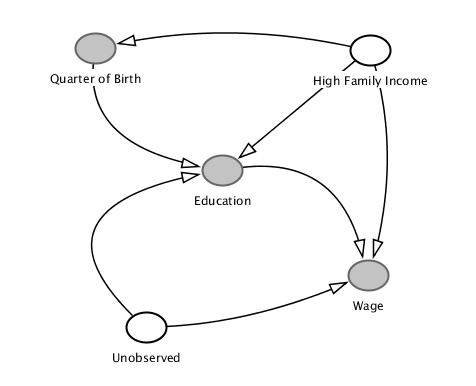

In [21]:
Image('files/causal_graph_weak_instruments.png')

Assuming that childrens of families with high income are less likely to be born in winter months, the causal graph presented in the identification section changes. High family income would have an effect on quarter of birth, but also on education and wage, for example, because of access to better schools and access to high-paid jobs due to family connections. For unbiased estimates a control variable for high family income must be added. But unfortunately, in context of the provided sample high family income is unobserved.

Bound et al. also revisit the result of Table V of Angrist and Krueger (1991). Adding controls for race, residence in a SMSA and martial status to the OLS results in column (3) reduces the estimated effect of education from 0.0711 to 0.0632. Adding these controls to the TSLS results in column (4) reduces the the effect from 0.0760 to 0.0600. This implies an percentual change of 11% for OLS and 21% for TSLS. The larger drop in the estimation results for two stage least squares indicate a association between quarter of birth and the controls. 

In [22]:
for i in range(1, 5):
    frac = len(df.loc[(df['RACE'] == 1) & (df['QOB'] == i)]) / len(df[df['RACE'] == 1])
    print(f'Fraction of black men born in quarter {i}: {frac:4.3f}')

print()
    
for i in range(1, 5):
    frac = len(df.loc[(df['RACE'] == 0) & (df['QOB'] == i)]) / len(df[df['RACE'] == 0])
    print(f'Fraction of white men born in quarter {i}: {frac:4.3f}')


print('\nMean education of white men: {:4.2f}'.format(df[df['RACE'] == 0]['EDUC'].mean()))
print('Mean education of black men: {:4.2f}'.format(df[df['RACE'] == 1]['EDUC'].mean()))

print('\nMean income of white men: {:4.2f}'.format(df[df['RACE'] == 0]['LWKLYWGE'].mean()))
print('Mean income of black men: {:4.2f}'.format(df[df['RACE'] == 1]['LWKLYWGE'].mean()))

Fraction of black men born in quarter 1: 0.254
Fraction of black men born in quarter 2: 0.248
Fraction of black men born in quarter 3: 0.256
Fraction of black men born in quarter 4: 0.241

Fraction of white men born in quarter 1: 0.247
Fraction of white men born in quarter 2: 0.243
Fraction of white men born in quarter 3: 0.264
Fraction of white men born in quarter 4: 0.246

Mean education of white men: 12.90
Mean education of black men: 11.25

Mean income of white men: 5.93
Mean income of black men: 5.54


The different patterns in quarter of birth for black and white men are a possible source for associations between quarter of birth and the covariates. Black men are more likely to be born in the first quarter than white men while white men are more likely to be born in the third quarter. Since the average income and education of black men is smaller, race contributes to lower education and wage in the first quarter.

Although the correlation between quarter of  birth and race is quite small, including race control varibles in the estimation leads to clear differences in the estimated effect.

In [23]:
df[dhlp.get_quarter_of_birth_dummy_names() + ['RACE']].corr()

,DUMMY_QOB_1,DUMMY_QOB_2,DUMMY_QOB_3,RACE
DUMMY_QOB_1,1.00e+00,-3.25e-01,-3.43e-01,4.53e-03
DUMMY_QOB_2,-3.25e-01,1.00e+00,-3.39e-01,3.19e-03
DUMMY_QOB_3,-3.43e-01,-3.39e-01,1.00e+00,-4.91e-03
RACE,4.53e-03,3.19e-03,-4.91e-03,1.00e+00


<h4 id='finite'>4.1.2 Finite-Sample Bias</h4>

Bound et. al state that the results of Angrist and Krueger could include a finite-sample bias in spite of the huge sample size, because of the weak correlation between education and quarter of birth. They reproduce the estimations while adding F-statistics for the joint statistical significance of the excluded instruments and the partial $R^{2}$ for the excluded instruments.

All specifications include race, SMSA and martial status dummies, and also eight region of residence dummies. For each specification OLS and IV estimates are presented. The first specification includes control variables for age and age squared. Excluded instruments are quarter of birth dummies. The second specification includes nine year of birth dummies and uses quarter of birth and interactions between quarter of birth and year of birth as excluded instruments. The third specification is similar to the second, but adds control variables for age and age squared.

In [24]:
df = dhlp.get_df_census80()
df = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)]

df = dhlp.prepare_census_data(df, qob_x_yob = True)
spec = rgr.get_specification_weak_instruments_table_1()

results = rgr.run_specification_iv2sls(df, spec)
f_test = rgr.f_test_excluded_instruments(df, spec)
r_squared = rgr.partial_r_squared_excluded_instruments(df, spec)

HTML(tbl.create_weak_instruments_table_1(results, f_test, r_squared))

instruments [exog instruments]  do not have full column rank
instruments [exog instruments]  do not have full column rank


D:\Softwareentwicklung\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 33, but rank is 30
  'rank is %d' % (J, J_), ValueWarning)
D:\Softwareentwicklung\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 33, but rank is 30
  'rank is %d' % (J, J_), ValueWarning)


,(1),(2),(3),(4),(5),(6)
,OLS,IV,OLS,IV,OLS,IV
Coefficient,0.0632,0.1422,0.0632,0.0806,0.0632,0.0600
,(0.0004),(0.0331),(0.0004),(0.0165),(0.0004),(0.0292)
F(excluded instruments),,13.4856,,4.7474,,2.6149
"Parital R squared (excluded instruments, x100)",,0.0123,,0.0432,,0.0137
,,,,,,
Age Control Variables,,,,,,
"Age, age squared",x,x,,,x,x
9 Year of birth dummies,,,x,x,x,x
,,,,,,


The F-statistic for the first specification does not allude on a possible finite sample bias. The F-statistics for the other two specifications are smaller and raise doubt on the results. But at least for the last specification the OLS estimate and the TSLS estimate are close to each other.
The partial $R^{2}$ is low for all specification. The explanatory power of the excluded instruments is similar in regression 2 and 6, although thirty interaction of quarter of birht and year of birth are added.

For the next table Bound et al. also added interaction of quarter of birth and state of birth to the excluded instruments. But this increases neither the F-statistics nor the $R^{2}$.

In [25]:
df = dhlp.get_df_census80()
df = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)]

state_list = dhlp.get_state_list(df)

df = dhlp.prepare_census_data(df, qob_x_yob = True, qob_x_state = state_list)
spec = rgr.get_specification_weak_instruments_table_2(state_list)

results = rgr.run_specification_iv2sls(df, spec)
f_test = rgr.f_test_excluded_instruments(df, spec)
r_squared = rgr.partial_r_squared_excluded_instruments(df, spec)

HTML(tbl.create_weak_instruments_table_2(results, f_test, r_squared))

instruments [exog instruments]  do not have full column rank
instruments [exog instruments]  do not have full column rank


D:\Softwareentwicklung\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 183, but rank is 180
  'rank is %d' % (J, J_), ValueWarning)
D:\Softwareentwicklung\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 183, but rank is 180
  'rank is %d' % (J, J_), ValueWarning)


,(1),(2),(3),(4)
,OLS,IV,OLS,IV
Coefficient,0.0628,0.0831,0.0628,0.0811
,(0.0004),(0.0098),(0.0004),(0.0111)
F(excluded instruments),,2.4276,,2.0587
"Parital R squared (excluded instruments, x100)",,0.1325,,0.1009
Age Control Variables,,,,
"Age, age squared",,,x,x
9 Year of birth dummies,x,x,x,x
,,,,
Excluded instruments,,,,


<h4 id='bias'>4.1.3 The Bias of 2SLS</h4>

In Angrist and Pischke (2009) the authors revisit the results from Angrist and Krueger (1991) discussing the critics of Bound, Jaeger and Baker (1995). Angrist also adds and F-Statistic of the joint significance of the excluded instruments. Additionally, for each specification the return of education is estimated using a limited information maximum likelihood estimator. This estimator is less precise than TSLS, but also less biased.
The first two specification using quarter of birth as exclued instrument. The first specification controls for year of birth, the second controls additionaly for age and age squared.
The next two specifications use interaction between quarter of birth and year of birth as excluded instruments. Again first the first estimates only control for year of birth and then age and age squared are added.
The last two specifications use interactions between quarter of birth and year of birth and interaction between quarter of birth and state of birth as excluded instruments. The control variables are as previously, but to both state of birth is added.

In [26]:
df = dhlp.get_df_census80()
df = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)]
state_list = dhlp.get_state_list(df)

df = dhlp.prepare_census_data(df, qob_x_yob = True, qob_x_state = state_list)
spec = rgr.get_specification_mstly_hrmlss_ecnmtrcs_table_4_6_2(state_list)

tsls = rgr.run_specification_iv2sls(df, spec)
liml = rgr.run_specification_ivliml(df, spec)
f_test = rgr.f_test_excluded_instruments(df, spec)

HTML(tbl.create_table_mstly_hrmlss_ecnmtrcs_4_6_2(tsls, liml, f_test))

instruments [exog instruments]  do not have full column rank
instruments [exog instruments]  do not have full column rank
instruments [exog instruments]  do not have full column rank
instruments [exog instruments]  do not have full column rank
instruments [exog instruments]  do not have full column rank
instruments [exog instruments]  do not have full column rank


,(1),(2),(3),(4),(5),(6)
2SLS,0.1053,0.4353,0.0891,0.0760,0.0928,0.0907
,(0.0201),(0.4465),(0.0162),(0.0292),(0.0097),(0.0110)
LIML,0.1064,0.5395,0.0929,0.0811,0.1064,0.1100
,(0.0208),(0.7050),(0.0196),(0.0597),(0.0150),(0.0204)
F-statistic (excluded instruments),32.2692,0.4014,4.9071,2.8314,2.5823,2.2094
,,,,,,
Controls,,,,,,
Year of birth,x,x,x,x,x,x
State of birth,,,,,x,x
"Age, age squared",,x,,x,,x


The F-statistic of the first specification is high, the LIML estimate is near by the TSLS estimate. Adding age control variables leads to a great decrease in the F-statistic, the results of the second specification are likely to be biased. Also the F-statistics of the last four specification are rather low, the results of TSLS and LIML are not far off. Therefore, if the TSLS estimates of Angrist and Krueger (1991) are biased, the bias is rather small (at least for the specifications tested above)

<h3 id='multcoll'>4.2 Problems with Multicollinearity</h3>

Some of the two-stage least squares configurations use interactions of quarter of birth and year of birth as excluded instruments while using year of birth and age as control variables. This configuration leads to problems with multicollinearity, because quarter of birth, year of birth and age are linearly dependent.

Multicollinearity prevents the application of the IV2SLS method, which is part of the linearmodels python module. This method checks if the matrix containing excluded instruments and control variables have full column rank. Because of the multicollinearity this test fails. To use this method anyway, the following code snippet presents a wrapper around IV2SLS mocking the check.

In [27]:
# wrapper for the IV2SLS method
def IV2SLS_wrapper(dependent, exog, endog, instruments):

    # try to run the IV2SLS method without mocking the validation
    try:
        rslt = IV2SLS(dependent, exog, endog, instruments).fit()
    except ValueError as e:
        print(str(e))

        # run the IV2LS method while mocking the validation
        with mock.patch('linearmodels.iv.model._IVModelBase._validate_inputs'):
            rslt = IV2SLS(dependent, exog, endog, instruments).fit()
    
    return rslt

An other possible solution to run a two-stage least squares regression is the double application of the ols method, which is part of the statsmodels python module. This method only reports problem with multicollinearity, but runs the regression nevertheless.

In [28]:
def IV2SLS_using_ols(dependent, exog, endog, instruments):
    """
    The IV2SLS method of the linearmodels module run a simple OLS regression,
    if only inputs for dependent and exog are provided.
    To provide a uniform interface this procedure is also implemented for this method.
    """
    # run tsls regression if all required variables are passed, otherwise run ols
    if endog and instruments:
         # predict the endog, using the results from first stage
        endog_pred = pd.Series(data = OLS(endog = endog, exog = pd.concat((exog, instruments), axis = 1)).fit().predict(), \
                               name = f'{endog.name}_predict')
        # run the second stage, effect of the predicted endog on dependent controlling for exog
        rslt = OLS(endog = dependent, exog = pd.concat((exog, endog_pred), axis = 1)).fit()

    else:
        rslt = OLS(endog = dependent, exog = exog).fit()
    
    return rslt

<h4 id='vif'>4.2.1 Variance Inflation Factor</h4>

The function variance_inflation_factor measures the increase of variance if an variable is added to the regression. The variance inflation factor is a measure for multicollinearity. High inflation factors signal that the variable is highly collinear with one of the other variables.

In [29]:
df = dhlp.get_df_census80()
df = df.loc[(df['YOB'] >= 30) & (df['YOB'] <= 39)]
df = dhlp.prepare_census_data(df)

X = patsy.dmatrix(' + '.join(rgr.get_quarter_of_birth_dummy_names() + \
                             rgr.get_year_of_birth_dummy_names() + \
                             rgr.get_age_control_names() + \
                             rgr.get_region_of_residence_dummies() + \
                             rgr.get_further_exogenous_regressors()),
                   df, return_type = 'dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif.round(1)

D:\Softwareentwicklung\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
D:\Softwareentwicklung\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,0.0,Intercept
1,inf,DUMMY_QOB_1
2,inf,DUMMY_QOB_2
3,inf,DUMMY_QOB_3
4,inf,DUMMY_YOB_0
5,inf,DUMMY_YOB_1
6,inf,DUMMY_YOB_2
7,inf,DUMMY_YOB_3
8,inf,DUMMY_YOB_4
9,inf,DUMMY_YOB_5


The results of the variance_inflation_factor method show the expected outcome: the quarter of birth dummies, year of birth dummies, age and age squared have high VIF factors. There are clearly problems with multicollinearty.
Since quarter of birth, year of birth and age are linear dependent, this result is not surprising.

<h3 id='mem'>4.3 Problems with Memory Usage</h3>

The samples provided by Angrist and Krueger contain large amounts of data. The sample size of the cohort of men born between 1920-29 is 247,199. The 1930-39 sample contains 329,509 observations and the 1940-49 sample contains 486,926 observations. Adding quarter of birth dummies, year of birth dummies, state of birth dummies, interaction of quarter of birth and year of birth and interaction of quarter of birth and state of birth increases the number of columns to about 250. Therefore, it is important to use appropriate datatypes to prevents unnecessary usage of memory.

Problems with Memory Usage are likely to occur when running multiple regressions. A pitfall is to underestimate the size of the regression result objects. Collecting a group of these objects often leads to huge memory usage.
One possible solution is to extract only the data needed from the regression results and drop the other. The following code presents a solutions, where only the required attributes of a regression result are stored in an object.

In [30]:
class SmallRegressionResult():
    """
    This class is initialized by passing a regression result of IV2SLS or OLS.
    The initialization method keeps only some of the attributes.
    Since this class can be used for results of IV2SLS and OLS,
    it contains check to lookup if attributes exist before accessing them.
    
    The list of attributes can be extended if addtional data is needed.
    """
    def __init__(self, regressionResult):
        
        self.params = regressionResult.params
        self.bse = regressionResult.bse if hasattr(regressionResult, 'bse') else None
        self.std_errors = regressionResult.std_errors if hasattr(regressionResult, 'std_errors') else None
        self.basmann_f = regressionResult.basmann_f if hasattr(regressionResult, 'basmann_f') else None
        

In [31]:
# wrapper for the IV2SLS method
def IV2SLS_wrapper(dependent, exog, endog, instruments, small_rslt = False):
    """
    If small_rslt is True, the method return a smaller version of the regression result
    using the SmallRegressionResult class.
    """
    # try to run the IV2SLS method without mocking the validation
    try:
        if small_rslt:
            rslt = SmallRegressionResult(IV2SLS(dependent, exog, endog, instruments).fit())
        else:
            rslt = IV2SLS(dependent, exog, endog, instruments).fit()
    except ValueError as e:
        print(str(e))

        # run the IV2LS method while mocking the validation
        with mock.patch('linearmodels.iv.model._IVModelBase._validate_inputs'):
            if small_rslt:
                rslt = SmallRegressionResult(IV2SLS(dependent, exog, endog, instruments).fit())
            else:
                rslt = IV2SLS(dependent, exog, endog, instruments).fit()
    
    return rslt

In [32]:
def IV2SLS_using_ols(dependent, exog, endog, instruments, small_rslt = False):
    """
    If small_rslt is True, the method return a smaller version of the regression result
    using the SmallRegressionResult class.
    
    
    The IV2SLS method of the linearmodels module run a simple OLS regression,
    if only inputs for dependent and exog are provided.
    To provide a uniform interface this procedure is also implemented for this method.
    """
    # run tsls regression if all required variables are passed, otherwise run ols
    if endog and instruments:
         # predict the endog, using the results from first stage
        endog_pred = pd.Series(data = OLS(endog = endog, exog = pd.concat((exog, instruments), axis = 1)).fit().predict(), \
                               name = f'{endog.name}_predict')
        # run the second stage, effect of the predicted endog on dependent controlling for exog
        if small_rslt:
            rslt = SmallRegressionResult(OLS(endog = dependent, exog = pd.concat((exog, endog_pred), axis = 1)).fit())
        else:
            rslt = OLS(endog = dependent, exog = pd.concat((exog, endog_pred), axis = 1)).fit()

    else:
        if small_rslt:
            rslt = SmallRegressionResult(OLS(endog = dependent, exog = exog).fit())
        else:
            rslt = OLS(endog = dependent, exog = exog).fit()
            
    return rslt

<h2 id='concl'>5. Conclusion</h2>

The results in Angrist and Krueger (1991) could be succefully replicated in this notebook. Only table 2 in the paper was not reproduced, because it is calculated using another sample of data. The regressions were well described and for some of the tables also Stata code was available. Problems occured especially regarding multicollinearity. Some of the regression specifications contained linear dependent variables. These regressions were not easy to run in python, because the appropriate module for two-stage least squares estimation terminates calculations, when multicollinearity is present. Another pitfall in reproducing the results was the huge sample size. Running regressions on this sample on a personal computer it is important to pay attention to the memory usage.

Additionaly, the notebook contains a reeximination of results from Bound, Jaeger and Baker (1995). The authors suspect problems inside the results of Angrist and Krueger (1991) due to the weakness of the used instruments. The results of their estimations are also replicated, only minor differences occur.

Angrist and Pischke (2009) present results regarding the weakness of the instruments in Angrist and Krueger (1991). This notebook contains also a successfull replication of their estimates.

Overall, the findings of Angrist and Krueger offer an interesting application of instrumental variables. Although the choice of instruments has been criticized the estimates of the return to education are quite reasonable. Regarding some of the specifications the existence of a bias is likely. Calculating the F-statistic of excluded instruments and partial $R^{2}$ is a good guidance.

<h2 id='ref'>6. References</h2>

<b>Joshua D. Angrist, Alan B. Krueger</b> Does Compulsory School Attendance Affect Schooling and Earnings?, The Quarterly Journal of Economics, Volume 106, Issue 4, November 1991, Pages 979–1014

<b>John Bound, David A. Jaeger & Regina M. Baker (1995)</b> Problems with Instrumental Variables Estimation when the Correlation between the Instruments and the Endogenous Explanatory Variable is Weak, Journal of the American Statistical Association, 90:430, 443-450

<b>Angrist, Joshua & Pischke, Jörn-Steffen (2009)</b>. Mostly Harmless Econometrics: An Empiricist's Companion. 